In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
import numpy as np
import cv2

In [ ]:
def preprocess_input(x):
    # Check if the image is grayscale
    if len(x.shape) == 2:
        # Convert grayscale to RGB
        x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)

    # Normalization of pixel values to be in the range [-1, 1]
    x /= 127.5
    x -= 1.0

    return x

In [ ]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(validation_split=0.10,
                                     rotation_range=90,
                                     brightness_range=[0.7, 0.9],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)


test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_dir = "./drive/MyDrive/Data/2ND_MODEL/train"
test_data_dir = "./drive/MyDrive/Data/2ND_MODEL/test"

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 676 images belonging to 2 classes.
Found 74 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50V2

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

        conv_base = ResNet50V2(weights='imagenet',
                                 input_shape=input_shape,
                                 include_top=False)

        # Defines how many layers to freeze during training.
        # Layers in the convolutional base are switched from trainable to non-trainable
        # depending on the size of the fine-tuning parameter.
        if fine_tune > 0:
            for layer in conv_base.layers[:-fine_tune]:
                layer.trainable = False
        else:
            for layer in conv_base.layers:
                layer.trainable = False

        # Create a new 'top' of the model (i.e. fully-connected layers).
        # This is 'bootstrapping' a new top_model onto the pretrained layers.
        top_model = conv_base.output
        top_model = Flatten(name="flatten")(top_model)
        top_model = Dense(512, activation='relu')(top_model)
        top_model = Dropout(0.4)(top_model)
        output_layer = Dense(n_classes, activation='softmax')(top_model)

        # Group the convolutional base and new fully-connected layers into a Model object.
        model = Model(inputs=conv_base.input, outputs=output_layer)

        # Compiles the model for training.
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes= 2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 500

resnet50v2_model = create_model(input_shape,
                                  n_classes,
                                  optim_1,
                                  fine_tune=0)
resnet50v2_model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

path_model = './drive/MyDrive/Data/models/ResNet50V2.hdf5'

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath = path_model,
                                  save_best_only=True,
                                  verbose=1)

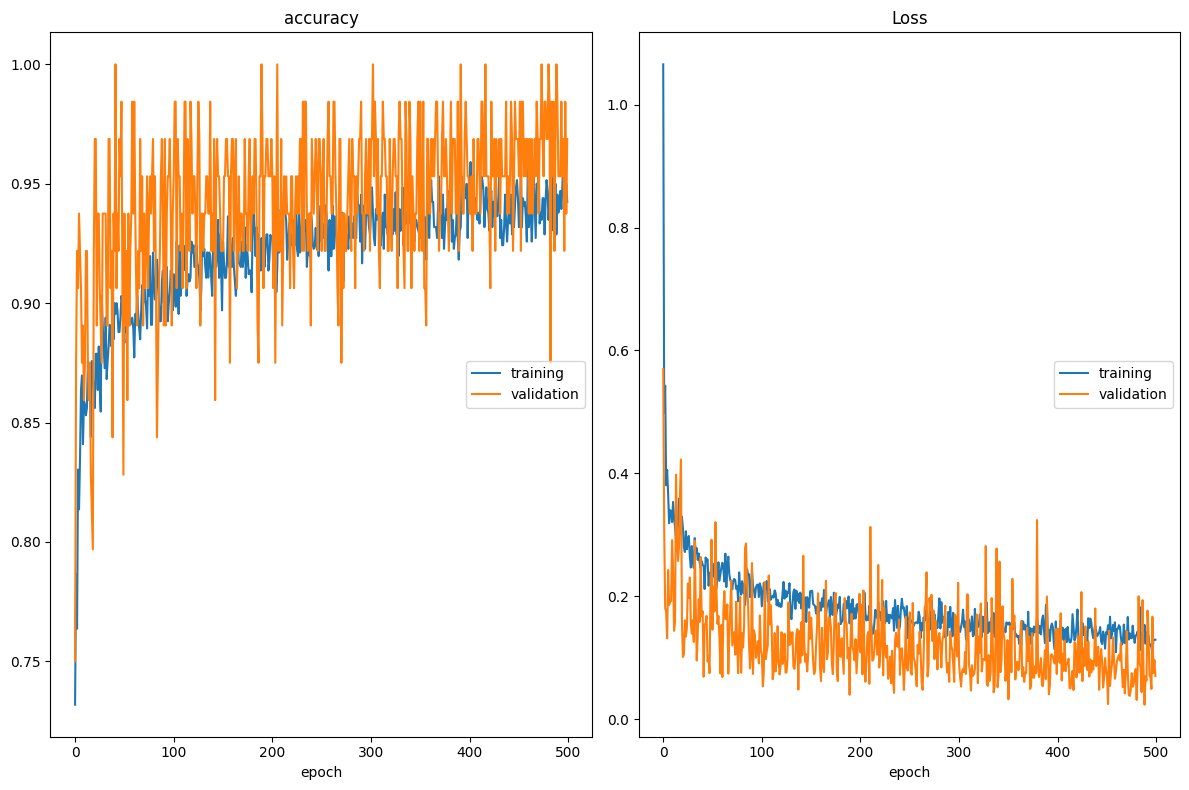

accuracy
	training         	 (min:    0.732, max:    0.962, cur:    0.942)
	validation       	 (min:    0.750, max:    1.000, cur:    0.969)
Loss
	training         	 (min:    0.106, max:    1.066, cur:    0.129)
	validation       	 (min:    0.023, max:    0.570, cur:    0.070)
42/42 [==============================] - 15s 356ms/step - loss: 0.1292 - accuracy: 0.9424 - val_loss: 0.0701 - val_accuracy: 0.9688
CPU times: user 2h 3min 5s, sys: 4min 10s, total: 2h 7min 16s
Wall time: 2h 37min 52s


In [ ]:
%%time

resnet50v2_history = resnet50v2_model.fit(traingen,
                                          batch_size=BATCH_SIZE,
                                          epochs=n_epochs,
                                          validation_data=validgen,
                                          steps_per_epoch=n_steps,
                                          validation_steps=n_val_steps,
                                          callbacks=[tl_checkpoint_1, plot_loss_1],
                                          verbose=1)

In [ ]:
# Generate predictions
# initialize the best trained weights
resnet50v2_model.load_weights(path_model)

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

resnet50v2_preds = resnet50v2_model.predict(testgen)
resnet50v2_pred_classes = np.argmax(resnet50v2_preds, axis=1)

93/93 [==============================] - 1s 11ms/step


In [ ]:
print(resnet50v2_pred_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
from sklearn.metrics import accuracy_score

resnet50v2_acc = accuracy_score(true_classes, resnet50v2_pred_classes)
print("ResNet50V2 Model Accuracy: {:.2f}%".format(resnet50v2_acc * 100))

ResNet50V2 Model Accuracy: 97.85%


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
# Save the model to a TFLite file
# Load the HDF5 model
loaded_model = load_model(path_model)

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
path_tflite = "./drive/MyDrive/Data/model_tflite/ResNet50V2.tflite"

with open(path_tflite, "wb") as f:
    f.write(tflite_model)

In [ ]:
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import average_precision_score, classification_report
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.preprocessing import image as tf_image

# Generate predictions
resnet50v2_model.load_weights(path_model)  # Load the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

resnet50v2_preds = resnet50v2_model.predict(testgen)
resnet50v2_pred_classes = np.argmax(resnet50v2_preds, axis=1)

# Calculate precision, recall, and classification report
precision = precision_score(true_classes,
                            resnet50v2_pred_classes,
                            average=None)

recall = recall_score(true_classes,
                      resnet50v2_pred_classes,
                      average=None)

classification_report = classification_report(true_classes,
                                              resnet50v2_pred_classes)

positive_precision = precision[1]  # Precision for positive class (class 1)
positive_recall = recall[1]  # Recall for positive class (class 1)

for class_index in range(n_classes):
    class_true = true_classes == class_index
    class_pred = resnet50v2_preds[:, class_index]
    precision, recall, _ = precision_recall_curve(class_true, class_pred)
    avg_precision = np.mean(precision)


print("Precision: {:.2f}".format(positive_precision))
print("Recall: {:.2f}".format(positive_recall))
print("Classification Report:\n", classification_report)

93/93 [==============================] - 2s 16ms/step
Precision: 0.98
Recall: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.98      0.98      0.98        59

    accuracy                           0.98        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.98      0.98      0.98        93



In [ ]:
import tensorflow as tf

def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [ ]:
estimated = get_flops(path_model)
print(estimated)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


61383782


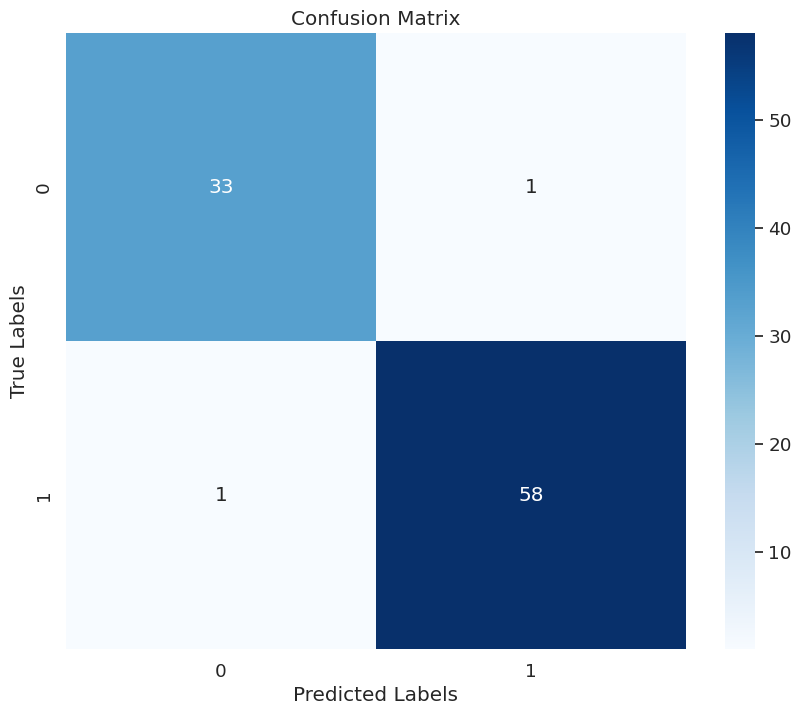

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_classes, resnet50v2_pred_classes)

# Define class labels if needed
class_labels = [str(i) for i in range(cm.shape[0])]  # Assuming classes are indexed from 0 to n_classes-1

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale if needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()